<a href="https://colab.research.google.com/github/MGonzalez506/Dimensionamiento_PV/blob/13-estimar-el-rendimiento-energ%C3%A9tico-del-sistema/Simulaci%C3%B3n_y_Dimensionamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Taller PVLIB

In [9]:
!pip install pvlib
!pip install rdtools

In [10]:
#Imports
import sys
import os
import traceback
import time
import signal
import fcntl
import string
import re
import itertools

import pytz
import pvlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from time import sleep
from datetime import datetime
from io import StringIO
from pvlib import solarposition
from pvlib import pvsystem
from pvlib import location
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib import irradiance
from pvlib import temperature
from rdtools import get_clearsky_tamb

In [11]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=12
fig_size[1]=8
plt.rcParams["figure.figsize"] = fig_size

site_tz='America/Costa_Rica'
site_lat = 9.84950
site_lon = -83.91289
site_name = 'Moren Centro de acondicionamiento Físico'
site_alt = 1425

glosario = {
      'sapm':'Sandia PV Array Performance Model',
      'sam':'System Advisor Model',
      'tmy':'Typical Meteorological Year Data',
      'ghi':'Radiación global Horizontal', 
      'dni':'Radiación directa', 
      'dhi':'Radiación difusa', 
      'IR(h)':'Índice de claridad', 
      'aoi':'Ángulo de incidencia', 
      'dni_extra':'Porcentaje de radiación extra',
      'POA':'Plane of Array'
      }

#Get modules & inverters
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('CECInverter')

module = (sandia_modules['Canadian_Solar_CS5P_220M___2009_'])
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

tmys = []
selected_months = []

coordinates = [
               (site_lat,site_lon,site_name,site_alt,site_tz)
]

In [12]:
def get_pvgis_tmy_from_coordinates(coordinates):
  tmys = []
  months = []
  for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    data_frame = pvlib.iotools.get_pvgis_tmy(latitude,longitude,map_variables=True)
    weather = data_frame[0]
    weather.index.name = 'utc_time'
    tmys.append(weather)
    months = data_frame[1]
  return tmys, months
tmys,selected_months = get_pvgis_tmy_from_coordinates(coordinates)

In [13]:
#Para realizar el cálculo del ángulo de inclinación óptima
system = {'module':module, 'inversor':inverter, 'surface_azimuth':180}
azimuth_testing = [0,90,180,270]
tilt_testing = [5,10,15]
energies = {}
selected_azimuth_angle = 180
selected_tilt_angle = 15
selected_data = pd.DataFrame()
selected_data_annual_energy = {}
for tilt_angle in tilt_testing:
  for azimuth_angle in azimuth_testing:
    for weather in tmys:
        location = coordinates[0]
        latitude, longitude, name, altitude, timezone = location
        system['surface_tilt']=tilt_angle
        system['surface_azimuth']=azimuth_angle
        solpos = pvlib.solarposition.get_solarposition(
            time=weather.index,
            latitude=latitude,
            longitude=longitude,
            altitude=altitude,
            temperature=weather['temp_air'],
            pressure=pvlib.atmosphere.alt2pres(altitude)
        )
        dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
        airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
        pressure = pvlib.atmosphere.alt2pres(altitude)
        am_abs = pvlib.atmosphere.get_absolute_airmass(airmass,pressure)
        aoi = pvlib.irradiance.aoi(
            system['surface_tilt'],
            system['surface_azimuth'],
            solpos['apparent_zenith'],
            solpos['azimuth']
        )
        #Irradiación total general
        total_irradiance = pvlib.irradiance.get_total_irradiance(
          system['surface_tilt'],
          system['surface_azimuth'],
          solpos['apparent_zenith'],
          solpos['azimuth'],
          weather['dni'],
          weather['ghi'],
          weather['dhi'],
          dni_extra=dni_extra,
          model='haydavies'
        )
        cell_temperature = pvlib.temperature.sapm_cell(
          total_irradiance['poa_global'],
          weather['temp_air'],
          weather['wind_speed'],
          **temperature_model_parameters     
        )
        #Irradiación efectiva
        effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
          total_irradiance['poa_direct'],
          total_irradiance['poa_diffuse'],
          am_abs,
          aoi,
          module
        )  
        dc=pvlib.pvsystem.sapm(effective_irradiance,cell_temperature,module)
        ac=pvlib.inverter.sandia(dc['v_mp'],dc['p_mp'],inverter)
        annual_energy = ac.sum()
        label = str(tilt_angle) + "º & " + str(azimuth_angle) + "Azi"
        energies[label] = annual_energy
        if selected_azimuth_angle == azimuth_angle and selected_tilt_angle == tilt_angle:
          selected_data = ac
          selected_data_annual_energy = annual_energy

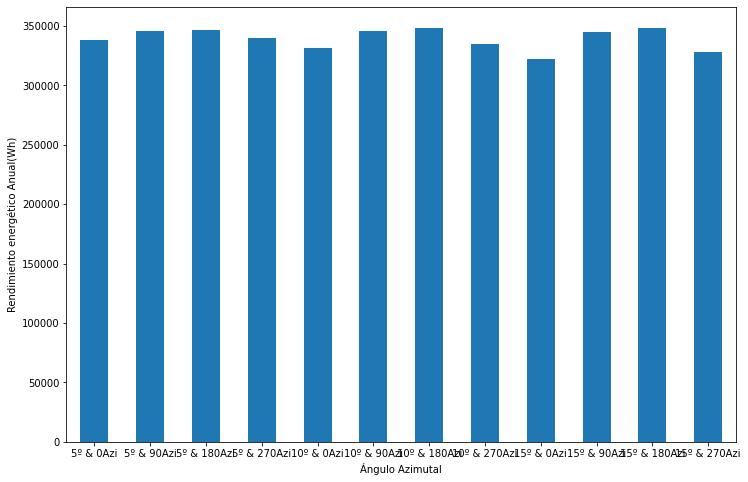

In [14]:
energies = pd.Series(energies)
energies.plot(kind='bar',rot=0)
plt.ylabel('Rendimiento energético anual(Wh)')
plt.xlabel('Ángulo Azimutal')
plt.show()

In [15]:
#print(last_ac.keys())
estudio_por_mes = {}
for i in selected_months:
  this_year = i['year']
  this_month = i['month']
  mes = str(this_year) + '-' + str(this_month) + '-01'
  x = selected_data.loc[mes:mes]
  sumatoria = x.sum()
  estudio_por_mes[mes] = float(sumatoria)

## Gráfico comparativo producción mensual vs producción anual para un ángulo de 10º



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  


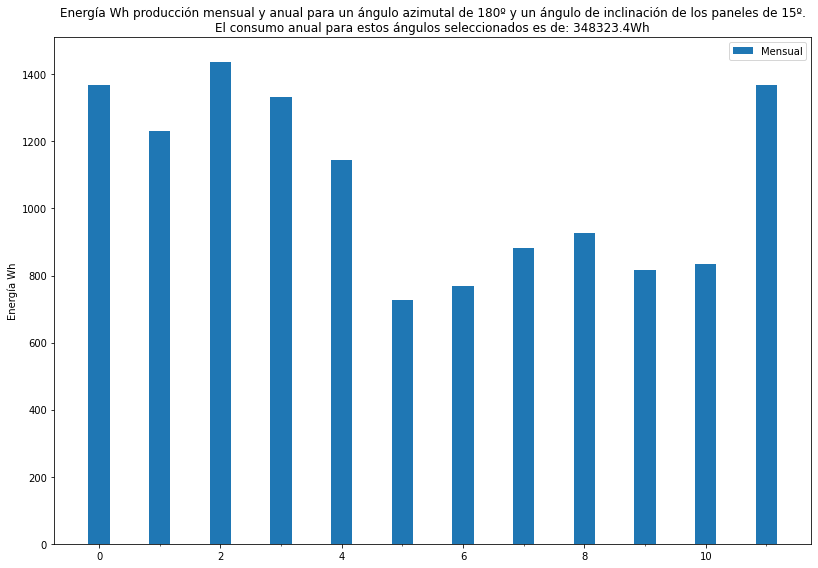








Vintage                                                          2009
Area                                                            1.701
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                          5.09115
Voco                                                          59.2608
Impo                                                          4.54629
Vmpo                                                          48.3156
Aisc                                                         0.000397
Aimp                                                         0.000181
C0                                                            1.01284
C1                                                           -0.01284
Bvoco                                                        -0.21696
Mbvoc        

In [16]:
estudio_por_mes = pd.Series(estudio_por_mes)
#print(selected_data_annual_energy)

labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Set', 'Oct', 'Nov', 'Dic']
#labels = estudio_por_mes.keys()
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rect1 = ax.bar(x, estudio_por_mes, width, label='Mensual')

ax.set_ylabel('Energía Wh')
ax.set_title('Energía Wh producción mensual y anual para un ángulo azimutal de ' + str(selected_azimuth_angle) + 'º y un ángulo de inclinación de los paneles de ' + str(selected_tilt_angle) + 'º.\nEl consumo anual para estos ángulos seleccionados es de: ' + str(selected_data_annual_energy.round(1)) + 'Wh')
ax.set_xticks(x, labels)
ax.legend()
#ax.bar_label(rect1, paadding=3)
fig.tight_layout()
plt.show()

print("\n\n\n\n====================================\n\n\n")
print(module)
print("\n\n\n\n====================================\n\n\n")
print(inverter)